Processing variable: predicted_temp
90th percentile (thr_90) for predicted_temp: 27.872328968048095
95th percentile (thr_95) for predicted_temp: 28.431256923675537


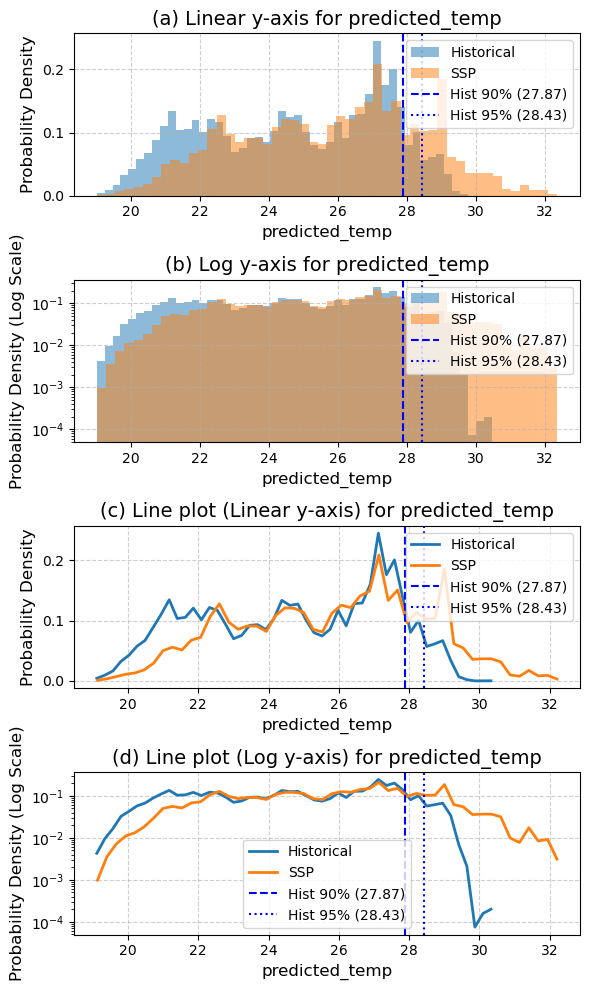

Processing variable: predicted_speed
90th percentile (thr_90) for predicted_speed: 0.8014011090993881
95th percentile (thr_95) for predicted_speed: 0.8914286255836487


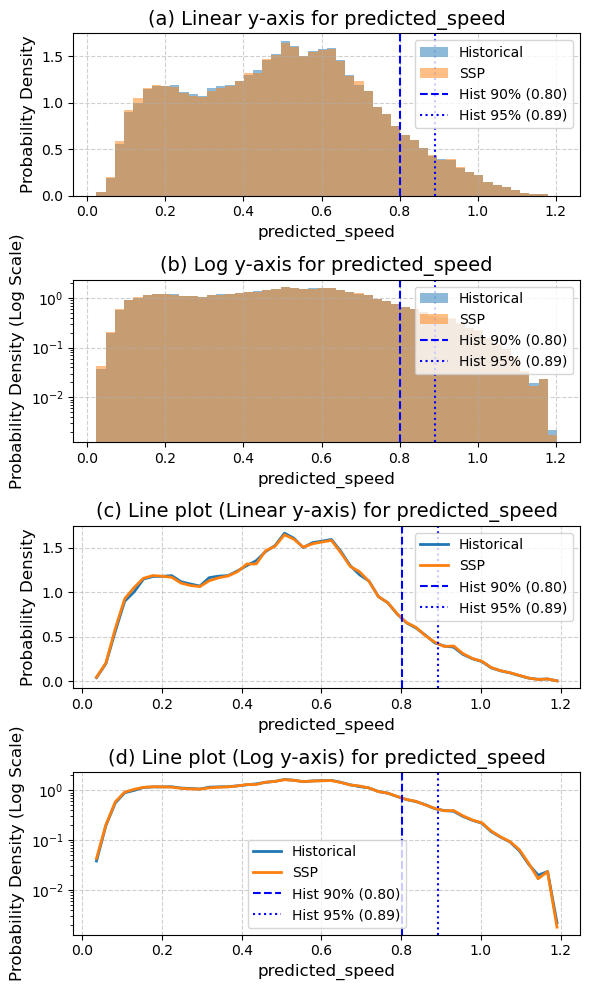

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme as gev
from sklearn.utils import resample

# Variables to process
variables = ['predicted_temp', 'predicted_speed']
variables_corrected = ['predicted_temp', 'predicted_speed']

# Flag for ship
ship = "gb"

# File paths (one file contains both raw and corrected variables)
file_hist_template = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/{{var}}_hist_{ship}.nc"
file_ssp_template = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/{{var}}_ssp_{ship}.nc"


def get_base_variable_name(var_name):
    """
    If var_name = 'predicted_temp_corrected',
    return 'predicted_temp'.
    Otherwise return var_name as is.
    """
    return var_name.replace('_corrected', '')

for variable in variables_corrected:
    print(f"Processing variable: {variable}")

    # Determine the correct file names by removing '_corrected'
    base_variable = get_base_variable_name(variable)
    file_hist = file_hist_template.format(var=base_variable)
    file_ssp = file_ssp_template.format(var=base_variable)

    # Read netCDF files that contain both raw and corrected variables
    try:
        data_hist = xr.open_dataset(file_hist)
        data_ssp = xr.open_dataset(file_ssp)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        continue

    # -------------------------------------------------
    # Extract the *corrected* variable from each dataset
    # -------------------------------------------------
    # Make sure the variable actually exists in the file
    if variable not in data_hist.variables:
        print(f"Variable '{variable}' not found in {file_hist}")
        continue
    if variable not in data_ssp.variables:
        print(f"Variable '{variable}' not found in {file_ssp}")
        continue

    hist_values = data_hist[variable].values.flatten()
    ssp_values = data_ssp[variable].values.flatten()


    # ------------------------------
    # Define thresholds for percentiles
    # ------------------------------
    thr_90 = np.percentile(hist_values, 90)
    thr_95 = np.percentile(hist_values, 95)

    # Print threshold values
    print(f"90th percentile (thr_90) for {variable}: {thr_90}")
    print(f"95th percentile (thr_95) for {variable}: {thr_95}")



    # ------------------------
    # Plot the PDFs
    # ------------------------
    fig, axes = plt.subplots(4, 1, figsize=(6, 10))

    # Panel (a): Linear y-axis
    axes[0].hist(hist_values, bins=50, density=True, alpha=0.5, label='Historical')
    axes[0].hist(ssp_values, bins=50, density=True, alpha=0.5, label='SSP')
    axes[0].axvline(thr_90, color='blue', linestyle='--', label=f'Hist 90% ({thr_90:.2f})')
    axes[0].axvline(thr_95, color='blue', linestyle=':', label=f'Hist 95% ({thr_95:.2f})')
    axes[0].set_xlabel(variable, fontsize=12)
    axes[0].set_ylabel('Probability Density', fontsize=12)
    axes[0].set_title(f'(a) Linear y-axis for {variable}', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Panel (b): Log y-axis
    axes[1].hist(hist_values, bins=50, density=True, alpha=0.5, label='Historical')
    axes[1].hist(ssp_values, bins=50, density=True, alpha=0.5, label='SSP')
    axes[1].axvline(thr_90, color='blue', linestyle='--', label=f'Hist 90% ({thr_90:.2f})')
    axes[1].axvline(thr_95, color='blue', linestyle=':', label=f'Hist 95% ({thr_95:.2f})')
    axes[1].set_yscale('log')
    axes[1].set_xlabel(variable, fontsize=12)
    axes[1].set_ylabel('Probability Density (Log Scale)', fontsize=12)
    axes[1].set_title(f'(b) Log y-axis for {variable}', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Panel (c): Line plot (Linear y-axis)
    hist_density, hist_bins = np.histogram(hist_values, bins=50, density=True)
    ssp_density, ssp_bins = np.histogram(ssp_values, bins=50, density=True)
    hist_bin_centers = 0.5 * (hist_bins[:-1] + hist_bins[1:])
    ssp_bin_centers = 0.5 * (ssp_bins[:-1] + ssp_bins[1:])
    axes[2].plot(hist_bin_centers, hist_density, label='Historical', linewidth=2)
    axes[2].plot(ssp_bin_centers, ssp_density, label='SSP', linewidth=2)
    axes[2].axvline(thr_90, color='blue', linestyle='--', label=f'Hist 90% ({thr_90:.2f})')
    axes[2].axvline(thr_95, color='blue', linestyle=':', label=f'Hist 95% ({thr_95:.2f})')
    axes[2].set_xlabel(variable, fontsize=12)
    axes[2].set_ylabel('Probability Density', fontsize=12)
    axes[2].set_title(f'(c) Line plot (Linear y-axis) for {variable}', fontsize=14)
    axes[2].legend(fontsize=10)
    axes[2].grid(True, linestyle='--', alpha=0.6)

    # Panel (d): Line plot (Log y-axis)
    axes[3].plot(hist_bin_centers, hist_density, label='Historical', linewidth=2)
    axes[3].plot(ssp_bin_centers, ssp_density, label='SSP', linewidth=2)
    axes[3].axvline(thr_90, color='blue', linestyle='--', label=f'Hist 90% ({thr_90:.2f})')
    axes[3].axvline(thr_95, color='blue', linestyle=':', label=f'Hist 95% ({thr_95:.2f})')
    axes[3].set_yscale('log')
    axes[3].set_xlabel(variable, fontsize=12)
    axes[3].set_ylabel('Probability Density (Log Scale)', fontsize=12)
    axes[3].set_title(f'(d) Line plot (Log y-axis) for {variable}', fontsize=14)
    axes[3].legend(fontsize=10)
    axes[3].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


Processing variable: predicted_pH
10th percentile (thr_10) for predicted_pH: 8.149122846529268
5th percentile (thr_05) for predicted_pH: 8.140670285221743
Adding threshold lines for 10% (thr_10: 8.149122846529268) and 5% (thr_05: 8.140670285221743) to the plots.


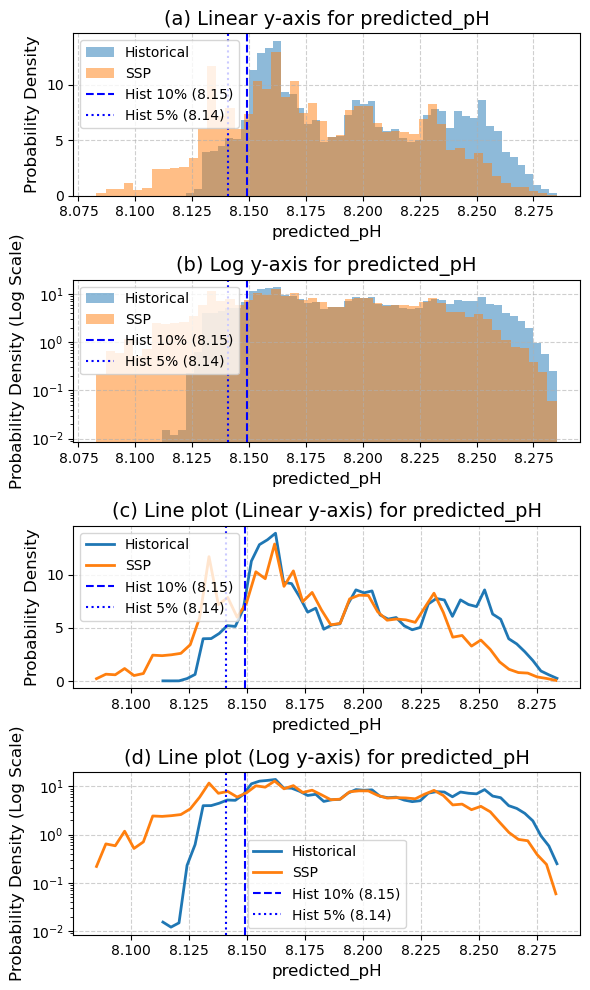

In [12]:
# Variables to process
variables = ['predicted_pH']
variables_corrected = ['predicted_pH']

# File paths
file_hist_template = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/{{var}}_hist_{ship}.nc"
file_ssp_template = f"/lfs/home/ioloi/lfs_dir/project_UCH/post_result/{{var}}_ssp_{ship}.nc"

# -------------------------------------------------
def get_base_variable_name(var_name):
    """
    If var_name = 'predicted_temp_corrected',
    return 'predicted_temp'.
    Otherwise return var_name as is.
    """
    return var_name.replace('_corrected', '')

for variable in variables_corrected:
    print(f"Processing variable: {variable}")

    # Determine the correct file names by removing '_corrected'
    base_variable = get_base_variable_name(variable)
    file_hist = file_hist_template.format(var=base_variable)
    file_ssp = file_ssp_template.format(var=base_variable)

    # Read netCDF files that contain both raw and corrected variables
    try:
        data_hist = xr.open_dataset(file_hist)
        data_ssp = xr.open_dataset(file_ssp)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        continue

    # Extract data
    hist_values = data_hist[variable].values.flatten()
    ssp_values = data_ssp[variable].values.flatten()



    # Define thresholds for 5% and 10% values
    thr_10 = np.percentile(hist_values, 10)
    thr_05 = np.percentile(hist_values, 5)


    # Print threshold values
    print(f"10th percentile (thr_10) for {variable}: {thr_10}")
    print(f"5th percentile (thr_05) for {variable}: {thr_05}")


    # Add threshold information to the plot
    print(f"Adding threshold lines for 10% (thr_10: {thr_10}) and 5% (thr_05: {thr_05}) to the plots.")


    # Plot the PDFs
    fig, axes = plt.subplots(4, 1, figsize=(6, 10))

    # Panel (a): Linear y-axis
    axes[0].hist(hist_values, bins=50, density=True, alpha=0.5, label='Historical')
    axes[0].hist(ssp_values, bins=50, density=True, alpha=0.5, label='SSP')
    axes[0].axvline(thr_10, color='blue', linestyle='--', label=f'Hist 10% ({thr_10:.2f})')
    axes[0].axvline(thr_05, color='blue', linestyle=':', label=f'Hist 5% ({thr_05:.2f})')
    axes[0].set_xlabel(variable, fontsize=12)
    axes[0].set_ylabel('Probability Density', fontsize=12)
    axes[0].set_title(f'(a) Linear y-axis for {variable}', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Panel (b): Log y-axis
    axes[1].hist(hist_values, bins=50, density=True, alpha=0.5, label='Historical')
    axes[1].hist(ssp_values, bins=50, density=True, alpha=0.5, label='SSP')
    axes[1].axvline(thr_10, color='blue', linestyle='--', label=f'Hist 10% ({thr_10:.2f})')
    axes[1].axvline(thr_05, color='blue', linestyle=':', label=f'Hist 5% ({thr_05:.2f})')
    axes[1].set_yscale('log')
    axes[1].set_xlabel(variable, fontsize=12)
    axes[1].set_ylabel('Probability Density (Log Scale)', fontsize=12)
    axes[1].set_title(f'(b) Log y-axis for {variable}', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Panel (c): Line plot (Linear y-axis)
    hist_density, hist_bins = np.histogram(hist_values, bins=50, density=True)
    ssp_density, ssp_bins = np.histogram(ssp_values, bins=50, density=True)
    hist_bin_centers = 0.5 * (hist_bins[:-1] + hist_bins[1:])
    ssp_bin_centers = 0.5 * (ssp_bins[:-1] + ssp_bins[1:])
    axes[2].plot(hist_bin_centers, hist_density, label='Historical', linewidth=2)
    axes[2].plot(ssp_bin_centers, ssp_density, label='SSP', linewidth=2)
    axes[2].axvline(thr_10, color='blue', linestyle='--', label=f'Hist 10% ({thr_10:.2f})')
    axes[2].axvline(thr_05, color='blue', linestyle=':', label=f'Hist 5% ({thr_05:.2f})')
    axes[2].set_xlabel(variable, fontsize=12)
    axes[2].set_ylabel('Probability Density', fontsize=12)
    axes[2].set_title(f'(c) Line plot (Linear y-axis) for {variable}', fontsize=14)
    axes[2].legend(fontsize=10)
    axes[2].grid(True, linestyle='--', alpha=0.6)

    # Panel (d): Line plot (Log y-axis)
    axes[3].plot(hist_bin_centers, hist_density, label='Historical', linewidth=2)
    axes[3].plot(ssp_bin_centers, ssp_density, label='SSP', linewidth=2)
    axes[3].axvline(thr_10, color='blue', linestyle='--', label=f'Hist 10% ({thr_10:.2f})')
    axes[3].axvline(thr_05, color='blue', linestyle=':', label=f'Hist 5% ({thr_05:.2f})')
    axes[3].set_yscale('log')
    axes[3].set_xlabel(variable, fontsize=12)
    axes[3].set_ylabel('Probability Density (Log Scale)', fontsize=12)
    axes[3].set_title(f'(d) Line plot (Log y-axis) for {variable}', fontsize=14)
    axes[3].legend(fontsize=10)
    axes[3].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()